In [ ]:


# Cell 1: Code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
import os
from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define paths
DATA_PATH = '../data/' 

print("Loading raw datasets...")
try:
    fraud_data_df_raw = pd.read_csv(os.path.join(DATA_PATH, 'Fraud_Data.csv'))
    ip_country_df_raw = pd.read_csv(os.path.join(DATA_PATH, 'IpAddress_to_Country.csv')) 
    print("Raw datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure the CSV files are in the '{DATA_PATH}' directory.")
    # Set to empty DataFrames if files are not found to prevent further errors
    fraud_data_df_raw = pd.DataFrame()
    ip_country_df_raw = pd.DataFrame()

Loading raw datasets...
Raw datasets loaded successfully.


In [25]:
# Cell 2: Code
print("--- Fraud_Data.csv - Initial Info ---")
if not fraud_data_df_raw.empty:
    print("Shape:", fraud_data_df_raw.shape)
    print("\nHead:\n", fraud_data_df_raw.head())
    print("\nInfo:\n")
    fraud_data_df_raw.info()
    print("\nDescription:\n", fraud_data_df_raw.describe(include='all'))
else:
    print("Fraud_Data.csv is empty or not loaded.")

print("\n--- IpAddress_to_Country.csv - Initial Info ---")
if not ip_country_df_raw.empty:
    print("Shape:", ip_country_df_raw.shape)
    print("\nHead:\n", ip_country_df_raw.head())
    print("\nInfo:\n")
    ip_country_df_raw.info()
    print("\nDescription:\n", ip_country_df_raw.describe(include='all'))
else:
    print("IpAddress_to_Country.csv is empty or not loaded.")



--- Fraud_Data.csv - Initial Info ---
Shape: (151112, 11)

Head:
    user_id          signup_time        purchase_time  purchase_value      device_id source browser sex  age    ip_address  class
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dty

In [26]:
 # cell  3
fraud_data_df = fraud_data_df_raw.copy()
ip_country_df = ip_country_df_raw.copy()

if fraud_data_df.empty or ip_country_df.empty:
    print("Skipping cleaning and merge steps due to empty DataFrames.")
else:
    print("--- Fraud_Data.csv - Cleaning ---")
    print("Missing values before handling:\n", fraud_data_df.isnull().sum())
    initial_rows_fraud = fraud_data_df.shape[0]
    fraud_data_df.dropna(inplace=True)
    print(f"Dropped {initial_rows_fraud - fraud_data_df.shape[0]} rows with missing values.")

    print("Converting time columns to datetime...")
    fraud_data_df['signup_time'] = pd.to_datetime(fraud_data_df['signup_time'])
    fraud_data_df['purchase_time'] = pd.to_datetime(fraud_data_df['purchase_time'])
    print("Data types after conversion for Fraud_Data.csv:")
    fraud_data_df[['signup_time', 'purchase_time']].info()

    print("Checking for duplicates...")
    initial_rows_fraud_after_na = fraud_data_df.shape[0]
    fraud_data_df.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows_fraud_after_na - fraud_data_df.shape[0]} duplicate rows.")
    print(f"Fraud_Data.csv shape after initial cleaning: {fraud_data_df.shape}")

    print("\n--- IpAddress_to_Country.csv - Cleaning ---")
    print("Missing values before handling:\n", ip_country_df.isnull().sum())
    initial_rows_ip_country = ip_country_df.shape[0]
    ip_country_df.dropna(inplace=True)
    print(f"Dropped {initial_rows_ip_country - ip_country_df.shape[0]} rows with missing values.")

    print("Checking for duplicates...")
    initial_rows_ip_country_after_na = ip_country_df.shape[0]
    ip_country_df.drop_duplicates(inplace=True)
    print(f"Removed {initial_rows_ip_country_after_na - ip_country_df.shape[0]} duplicate rows.")
    print(f"IpAddress_to_Country.csv shape after initial cleaning: {ip_country_df.shape}")

--- Fraud_Data.csv - Cleaning ---
Missing values before handling:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Dropped 0 rows with missing values.
Converting time columns to datetime...
Data types after conversion for Fraud_Data.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   signup_time    151112 non-null  datetime64[ns]
 1   purchase_time  151112 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.3 MB
Checking for duplicates...
Removed 0 duplicate rows.
Fraud_Data.csv shape after initial cleaning: (151112, 11)

--- IpAddress_to_Country.csv - Cleaning ---
Missing values before handling:
 lower_bound_ip_address 

In [ ]:
# Cell 4
def numeric_ip_to_int(ip_val):
    """Converts a numerical IP address representation (float/int) to an integer."""
    if pd.isna(ip_val):
        return np.nan
    try:
        return int(ip_val)
    except (ValueError, TypeError): # Catch if it's not a valid number
        return np.nan


if fraud_data_df.empty or ip_country_df.empty:
    print("Skipping IP to Country merge due to empty DataFrames from previous steps.")
else:
    print("Converting 'ip_address' (float) to integer in Fraud_Data.csv...")
    fraud_data_df['ip_address_int'] = fraud_data_df['ip_address'].apply(numeric_ip_to_int)
    initial_rows_fraud_ip_int = fraud_data_df.shape[0]
    fraud_data_df.dropna(subset=['ip_address_int'], inplace=True)
    print(f"Dropped {initial_rows_fraud_ip_int - fraud_data_df.shape[0]} rows due to invalid IP address conversion.")
    if not fraud_data_df.empty:
        fraud_data_df['ip_address_int'] = fraud_data_df['ip_address_int'].astype(int)

    print("Converting IP range columns (float) to integer in IpAddress_to_Country.csv...")
    ip_country_df['lower_bound_ip_address_int'] = ip_country_df['lower_bound_ip_address'].apply(numeric_ip_to_int)
    ip_country_df['upper_bound_ip_address_int'] = ip_country_df['upper_bound_ip_address'].apply(numeric_ip_to_int)
    initial_rows_ip_country_int = ip_country_df.shape[0]
    ip_country_df.dropna(subset=['lower_bound_ip_address_int', 'upper_bound_ip_address_int'], inplace=True)
    print(f"Dropped {initial_rows_ip_country_int - ip_country_df.shape[0]} rows due to invalid IP range conversion.")
    if not ip_country_df.empty:
        ip_country_df['lower_bound_ip_address_int'] = ip_country_df['lower_bound_ip_address_int'].astype(int)
        ip_country_df['upper_bound_ip_address_int'] = ip_country_df['upper_bound_ip_address_int'].astype(int)

    ip_country_df_sorted = ip_country_df.sort_values(by='lower_bound_ip_address_int').reset_index(drop=True)

    # This function remains the same as its logic for finding the country in the sorted range is correct.
    def get_country_from_ip(ip_int, ip_country_df_sorted):
        mask = (ip_int >= ip_country_df_sorted['lower_bound_ip_address_int']) & \
               (ip_int <= ip_country_df_sorted['upper_bound_ip_address_int'])
        matching_countries = ip_country_df_sorted.loc[mask, 'country']
        if not matching_countries.empty:
            return matching_countries.iloc[0]
        return np.nan

    print("Mapping IP addresses to countries (this may take some time)...")
    if not fraud_data_df.empty: # Only attempt to merge if fraud_data_df is not empty
        fraud_data_df['country'] = fraud_data_df['ip_address_int'].apply(lambda x: get_country_from_ip(x, ip_country_df_sorted))

        initial_rows_after_country_map = fraud_data_df.shape[0]
        fraud_data_df.dropna(subset=['country'], inplace=True)
        print(f"Dropped {initial_rows_after_country_map - fraud_data_df.shape[0]} rows where country could not be mapped.")
    else:
        print("Skipping country mapping as fraud_data_df is already empty.")

    # Convert target column to categorical type explicitly for seaborn and proper handling
    print("\nConverting target 'class' column to categorical dtype for EDA consistency...")
    if not fraud_data_df.empty and 'class' in fraud_data_df.columns:
        fraud_data_df['class'] = fraud_data_df['class'].astype('category')

    print("\nFraud_Data.csv after initial preprocessing, country merge, and class type conversion:")
    if not fraud_data_df.empty:
        print(fraud_data_df.head())
        fraud_data_df.info()
    else:
        print("Fraud_Data.csv is empty.")

Converting 'ip_address' (float) to integer in Fraud_Data.csv...
Dropped 0 rows due to invalid IP address conversion.
Converting IP range columns (float) to integer in IpAddress_to_Country.csv...
Dropped 0 rows due to invalid IP range conversion.
Mapping IP addresses to countries (this may take some time)...
Dropped 21966 rows where country could not be mapped.

Converting target 'class' column to categorical dtype for EDA consistency...

Fraud_Data.csv after initial preprocessing, country merge, and class type conversion:
   user_id         signup_time       purchase_time  purchase_value      device_id source browser sex  age    ip_address class  ip_address_int        country
0    22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08     0       732758368          Japan
1   333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08     0       350311387  United States
2

Class distribution for 'class' (target variable):
class
0    90.500674
1     9.499326
Name: proportion, dtype: float64


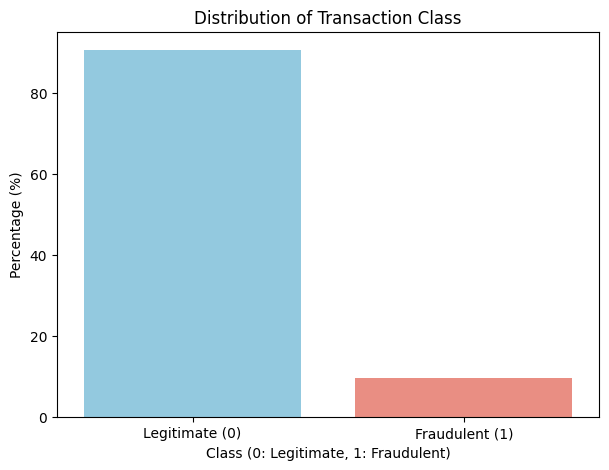

/tmp/ipykernel_157682/3228341568.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
/tmp/ipykernel_157682/3228341568.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
/tmp/ipykernel_157682/3228341568.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
/tmp

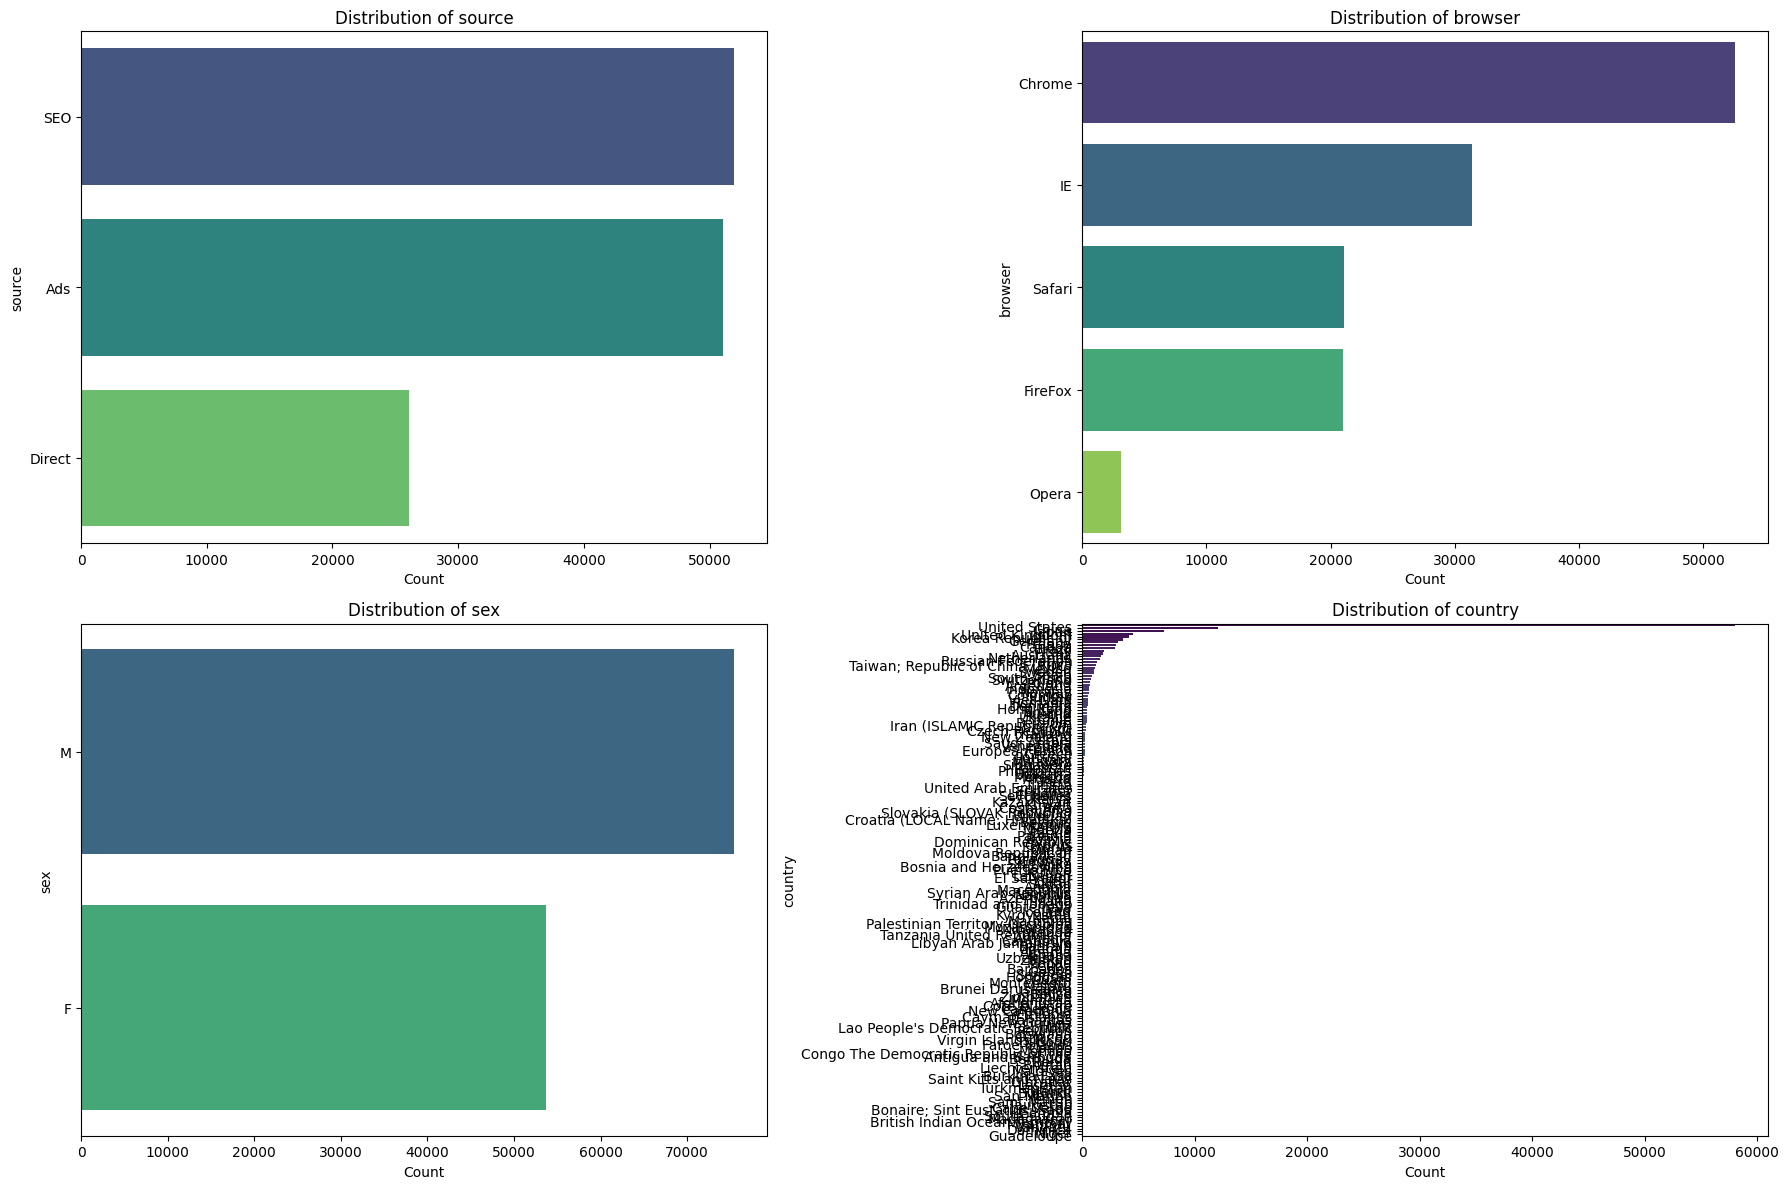

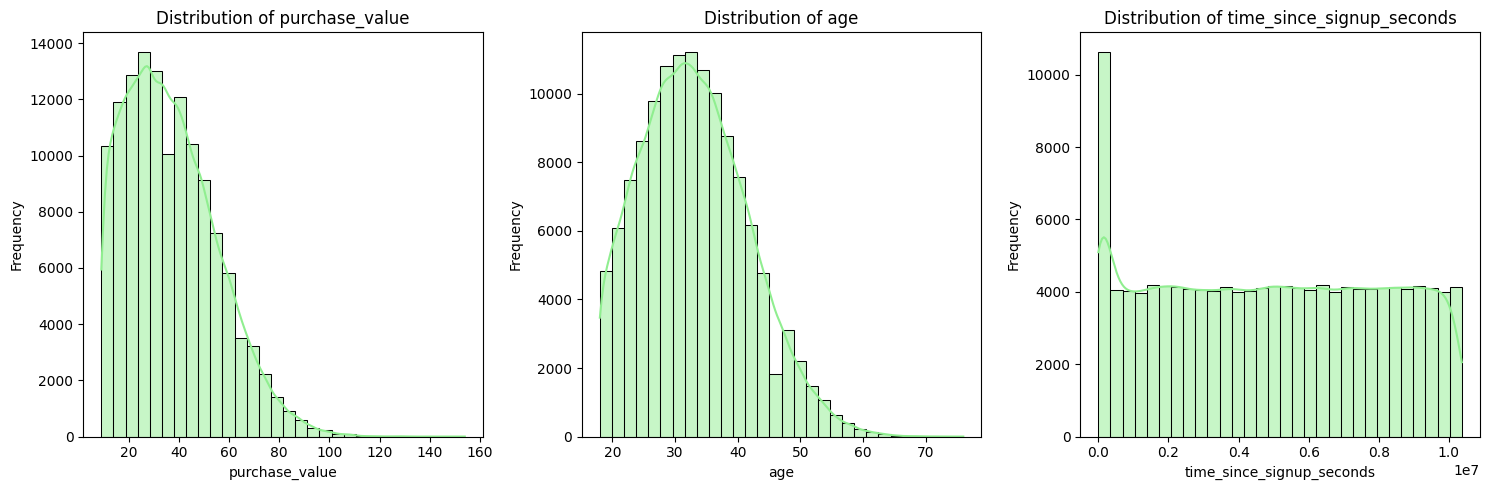

In [ ]:
# Cell 5 
if fraud_data_df.empty:
    print("Skipping EDA as fraud_data_df is empty.")
else:
   
    print("Class distribution for 'class' (target variable):")
    class_distribution = fraud_data_df['class'].value_counts(normalize=True) * 100
    print(class_distribution)

    plt.figure(figsize=(7, 5))
    sns.barplot(x=class_distribution.index, y=class_distribution.values, hue=class_distribution.index, palette=['skyblue', 'salmon'], legend=False)
    plt.title('Distribution of Transaction Class')
    plt.xlabel('Class (0: Legitimate, 1: Fraudulent)')
    plt.ylabel('Percentage (%)')
    plt.xticks(ticks=[0, 1], labels=['Legitimate (0)', 'Fraudulent (1)'])
    plt.show()


   
    categorical_cols = ['source', 'browser', 'sex', 'country']

    plt.figure(figsize=(18, 12))
    for i, col in enumerate(categorical_cols):
        plt.subplot(2, 2, i + 1)
        sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    if not fraud_data_df.empty and 'purchase_time' in fraud_data_df.columns and 'signup_time' in fraud_data_df.columns:
        fraud_data_df['time_since_signup_seconds'] = (fraud_data_df['purchase_time'] - fraud_data_df['signup_time']).dt.total_seconds()
        fraud_data_df['time_since_signup_seconds'] = fraud_data_df['time_since_signup_seconds'].apply(lambda x: max(x, 0))
    else:
        # If fraud_data_df is empty or time columns are missing, ensure time_since_signup_seconds is added but will be NaN
        fraud_data_df['time_since_signup_seconds'] = np.nan
        print("Warning: 'time_since_signup_seconds' could not be computed, column might be missing or empty.")


    numerical_cols = ['purchase_value', 'age', 'time_since_signup_seconds']

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(numerical_cols):
        plt.subplot(1, 3, i + 1)
        sns.histplot(fraud_data_df[col], kde=True, bins=30, color='lightgreen')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

Class distribution for 'class' (target variable):
class
0    90.500674
1     9.499326
Name: proportion, dtype: float64


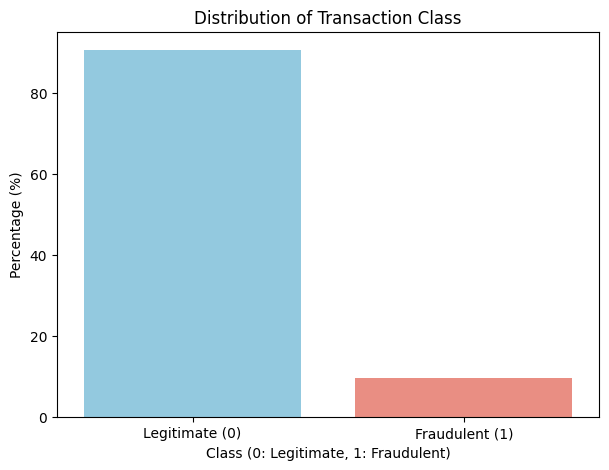

/tmp/ipykernel_157682/149773612.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
/tmp/ipykernel_157682/149773612.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
/tmp/ipykernel_157682/149773612.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
/tmp/ip

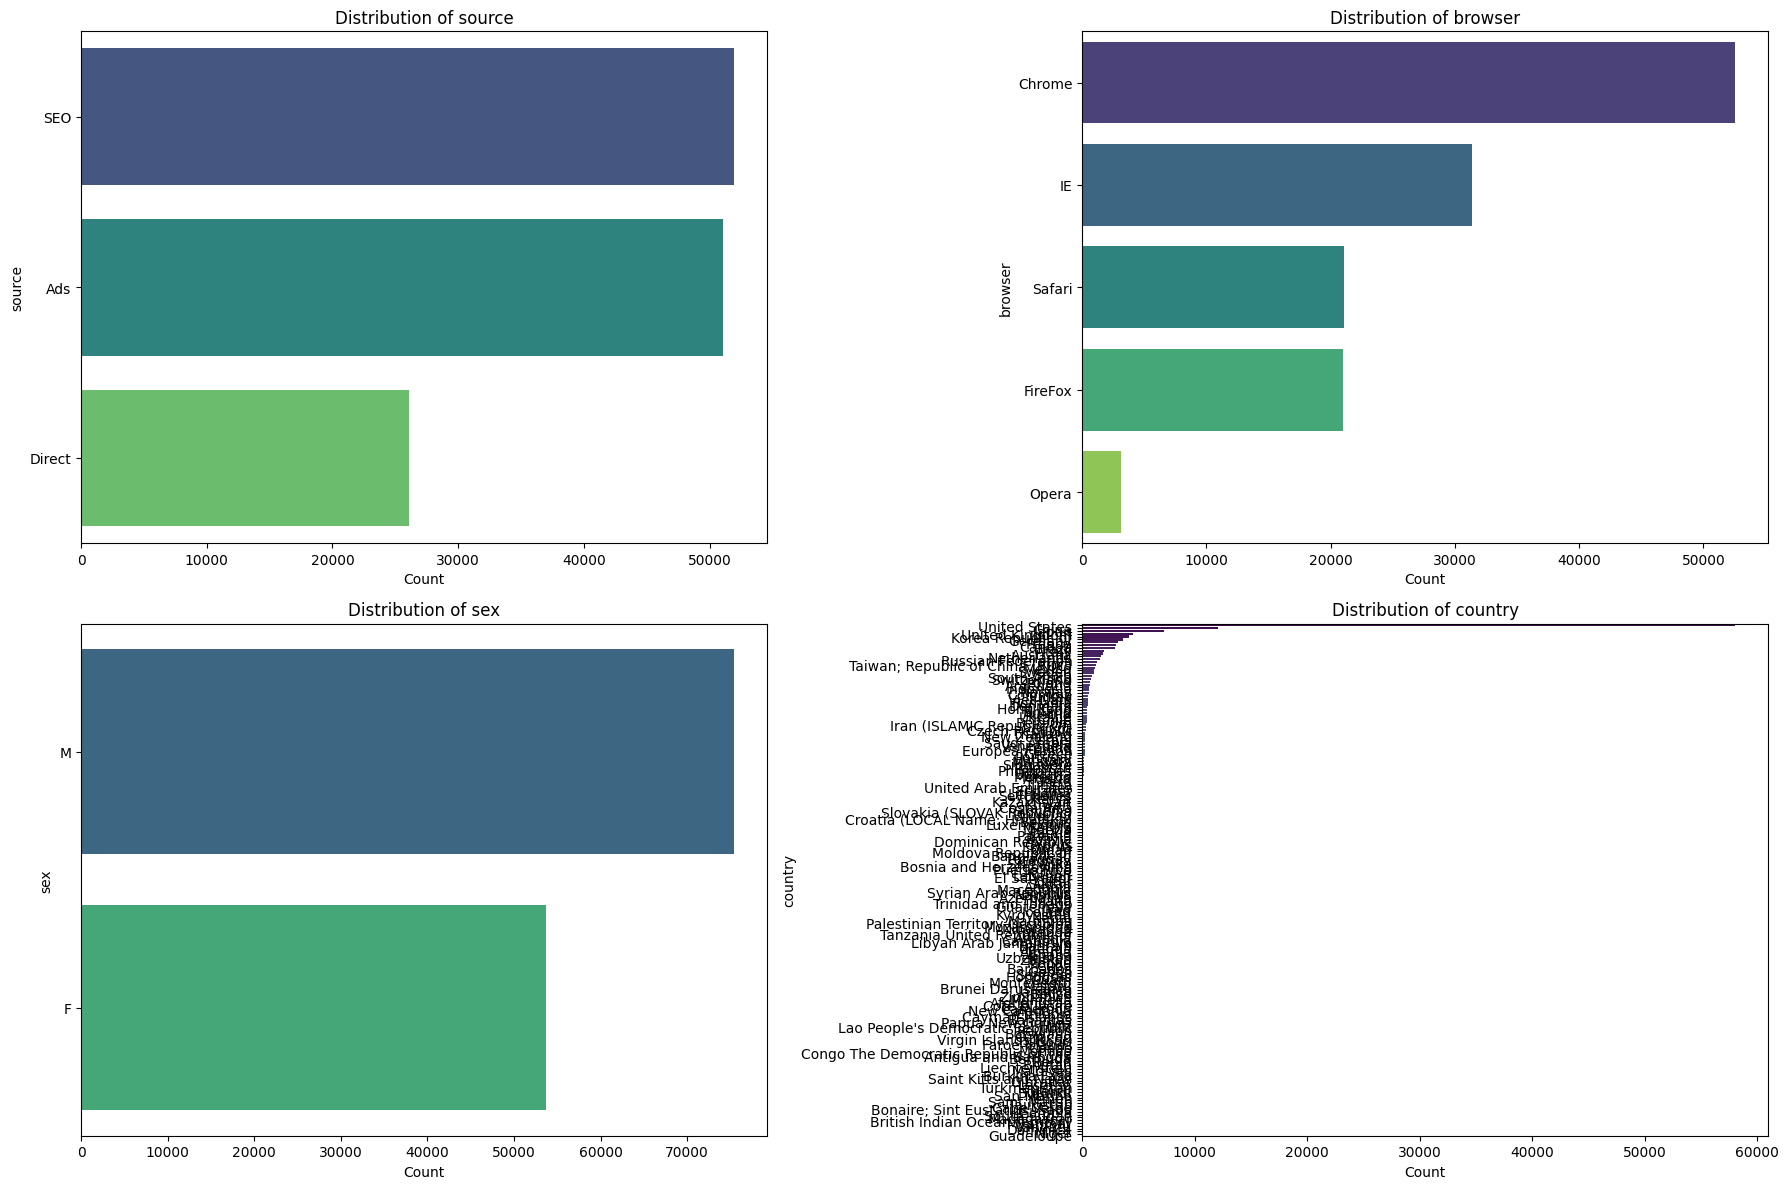

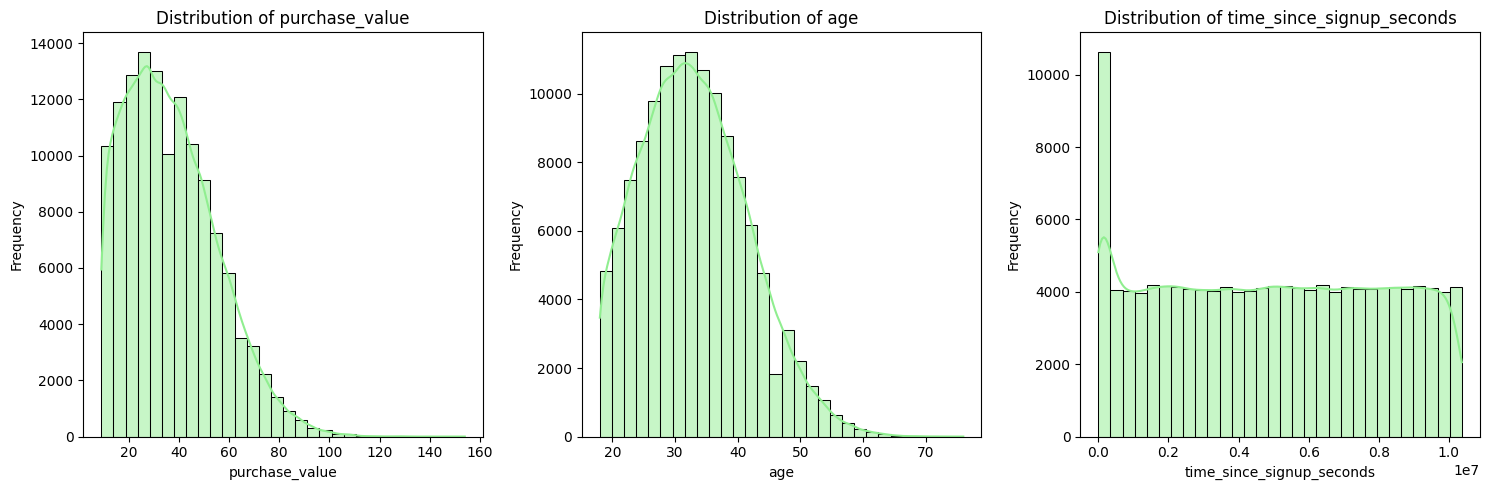

In [ ]:
# Cell 6

if fraud_data_df.empty:
    print("Skipping EDA as fraud_data_df is empty.")
else:
   
    print("Class distribution for 'class' (target variable):")
    class_distribution = fraud_data_df['class'].value_counts(normalize=True) * 100
    print(class_distribution)

    plt.figure(figsize=(7, 5))
    sns.barplot(x=class_distribution.index, y=class_distribution.values, hue=class_distribution.index, palette=['skyblue', 'salmon'], legend=False)
    plt.title('Distribution of Transaction Class')
    plt.xlabel('Class (0: Legitimate, 1: Fraudulent)')
    plt.ylabel('Percentage (%)')
    plt.xticks(ticks=[0, 1], labels=['Legitimate (0)', 'Fraudulent (1)'])
    plt.show()

    categorical_cols = ['source', 'browser', 'sex', 'country']

    plt.figure(figsize=(18, 12))
    for i, col in enumerate(categorical_cols):
        plt.subplot(2, 2, i + 1)
        sns.countplot(y=col, data=fraud_data_df, order=fraud_data_df[col].value_counts().index, palette='viridis')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

   
    if not fraud_data_df.empty and 'purchase_time' in fraud_data_df.columns and 'signup_time' in fraud_data_df.columns:
        fraud_data_df['time_since_signup_seconds'] = (fraud_data_df['purchase_time'] - fraud_data_df['signup_time']).dt.total_seconds()
        fraud_data_df['time_since_signup_seconds'] = fraud_data_df['time_since_signup_seconds'].apply(lambda x: max(x, 0))
    else:
        # If fraud_data_df is empty or time columns are missing, ensure time_since_signup_seconds is added but will be NaN
        fraud_data_df['time_since_signup_seconds'] = np.nan
        print("Warning: 'time_since_signup_seconds' could not be computed, column might be missing or empty.")


    numerical_cols = ['purchase_value', 'age', 'time_since_signup_seconds']

    plt.figure(figsize=(15, 5))
    for i, col in enumerate(numerical_cols):
        plt.subplot(1, 3, i + 1)
        sns.histplot(fraud_data_df[col], kde=True, bins=30, color='lightgreen')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_157682/1161702647.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate.values, y=fraud_rate.index, palette='coolwarm')
/tmp/ipykernel_157682/1161702647.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate.values, y=fraud_rate.index, palette='coolwarm')
/tmp/ipykernel_157682/1161702647.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate.values, y=fraud_rate.index, palette='coolwarm')
/tmp/ipykernel_157682/1161702647.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is depr

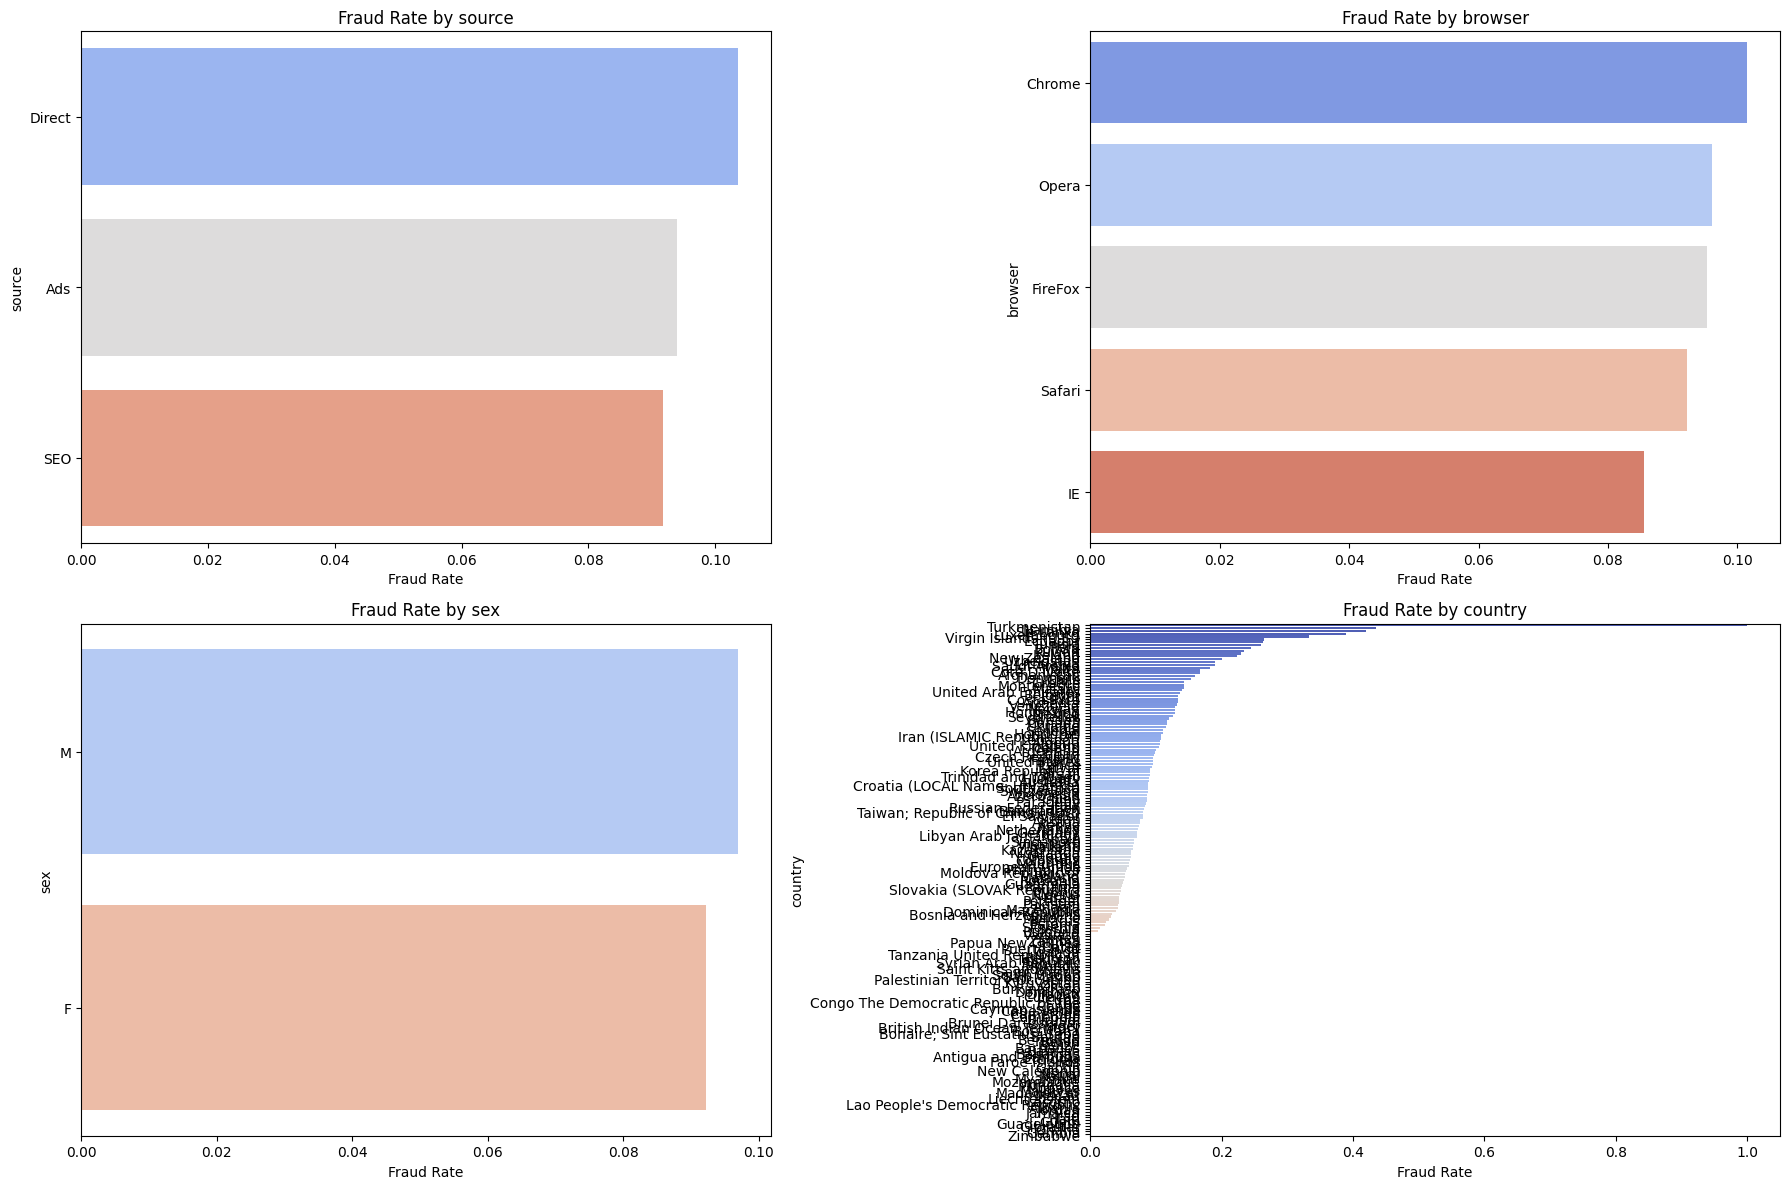


Top 10 Countries by Fraud Rate:
country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

Bottom 10 Countries by Fraud Rate (where fraud exists):
country
Afghanistan    1.0
Algeria        1.0
Angola         1.0
Argentina      1.0
Armenia        1.0
Australia      1.0
Austria        1.0
Azerbaijan     1.0
Bangladesh     1.0
Belarus        1.0
Name: class, dtype: float64


/tmp/ipykernel_157682/1161702647.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=col, data=fraud_data_df, palette=['skyblue', 'salmon'])
/tmp/ipykernel_157682/1161702647.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=col, data=fraud_data_df, palette=['skyblue', 'salmon'])
/tmp/ipykernel_157682/1161702647.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=col, data=fraud_data_df, palette=['skyblue', 'salmon'])


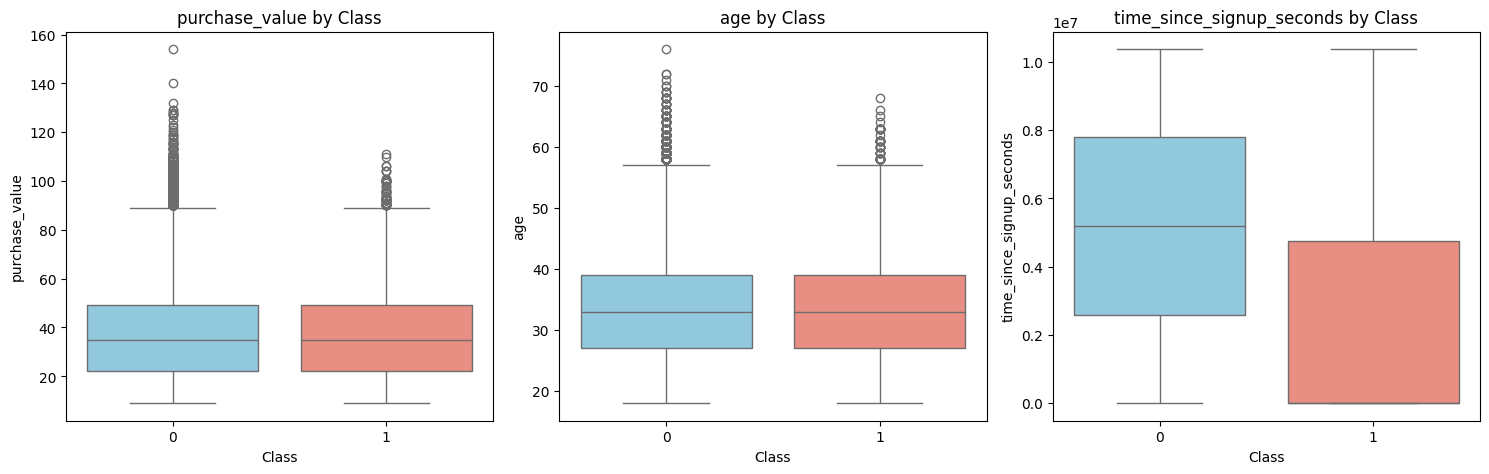

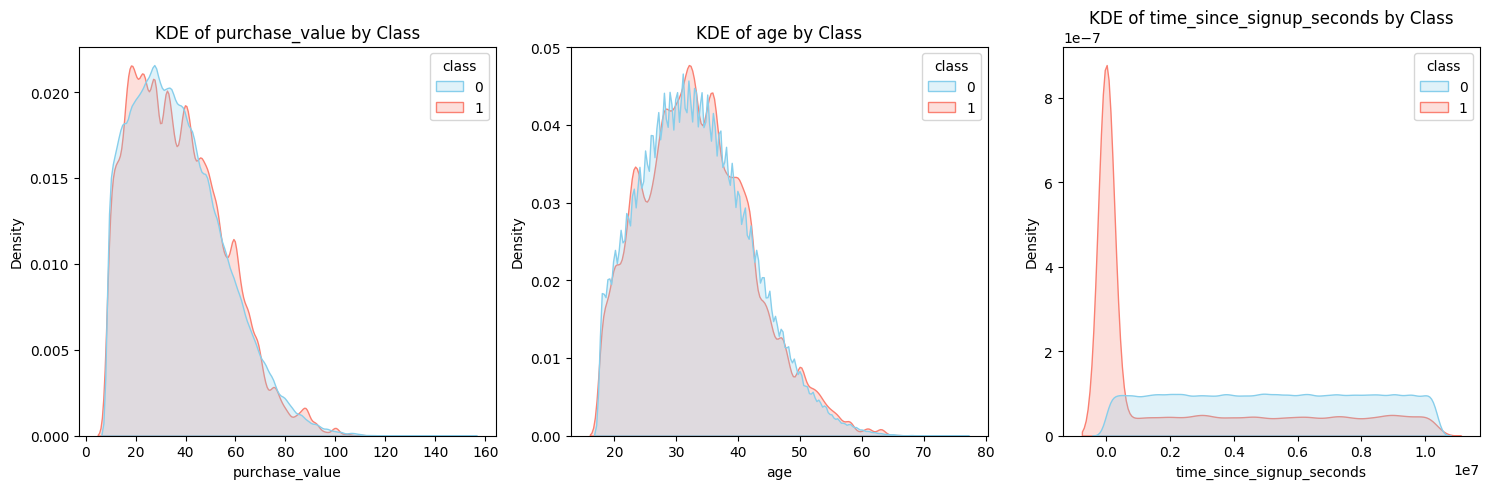

In [ ]:
# Cell 7
if fraud_data_df.empty:
    print("Skipping Bivariate Analysis as fraud_data_df is empty.")
else:
  
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(categorical_cols):
        plt.subplot(2, 2, i + 1)
        fraud_rate = fraud_data_df.groupby(col)['class'].apply(lambda x: x.astype(int).mean()).sort_values(ascending=False)
        

        sns.barplot(x=fraud_rate.values, y=fraud_rate.index, palette='coolwarm')
        plt.title(f'Fraud Rate by {col}')
        plt.xlabel('Fraud Rate')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Special insights for Country
    print("\nTop 10 Countries by Fraud Rate:")
   
    print(fraud_data_df.groupby('country')['class'].apply(lambda x: x.astype(int).mean()).nlargest(10))
    #

    print("\nBottom 10 Countries by Fraud Rate (where fraud exists):")
 
    print(fraud_data_df[fraud_data_df['class'] == 1].groupby('country')['class'].apply(lambda x: x.astype(int).mean()).nsmallest(10))
    


    # 5.2. Numerical Features vs. Fraud
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(['purchase_value', 'age', 'time_since_signup_seconds']):
        plt.subplot(1, 3, i + 1)
        sns.boxplot(x='class', y=col, data=fraud_data_df, palette=['skyblue', 'salmon'])
        plt.title(f'{col} by Class')
        plt.xlabel('Class')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    # Use KDE plots for numerical features to see distribution overlap/separation
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(['purchase_value', 'age', 'time_since_signup_seconds']):
        plt.subplot(1, 3, i + 1)
 
        if fraud_data_df['class'].nunique() < 2:
            print(f"Skipping KDE plot for '{col}' as only one class ({fraud_data_df['class'].unique()[0]}) is present in the dataframe subset for this plot.")
            # Optionally, plot just the existing class as a histogram
            sns.histplot(data=fraud_data_df, x=col, kde=True, fill=True, color='gray')
            plt.title(f'Distribution of {col} (Only one class)')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        else:
            # Explicitly define hue_order and palette for clarity and robustness
            sns.kdeplot(
                data=fraud_data_df,
                x=col,
                hue='class',
                hue_order=[0, 1], # Ensure consistent order of classes
                fill=True,
                common_norm=False,
                palette=['skyblue', 'salmon'], 
                bw_adjust=0.5 
            )
            plt.title(f'KDE of {col} by Class')
            plt.xlabel(col)
            plt.ylabel('Density')
      
    plt.tight_layout()
    plt.show()


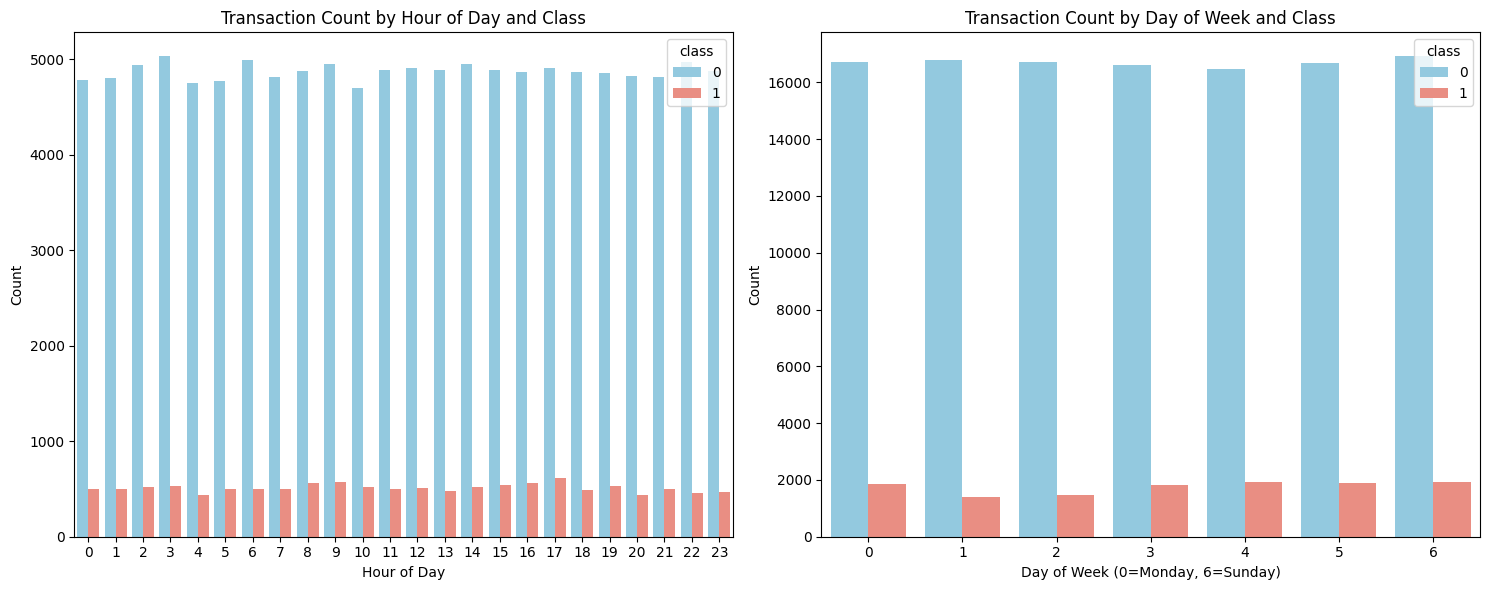

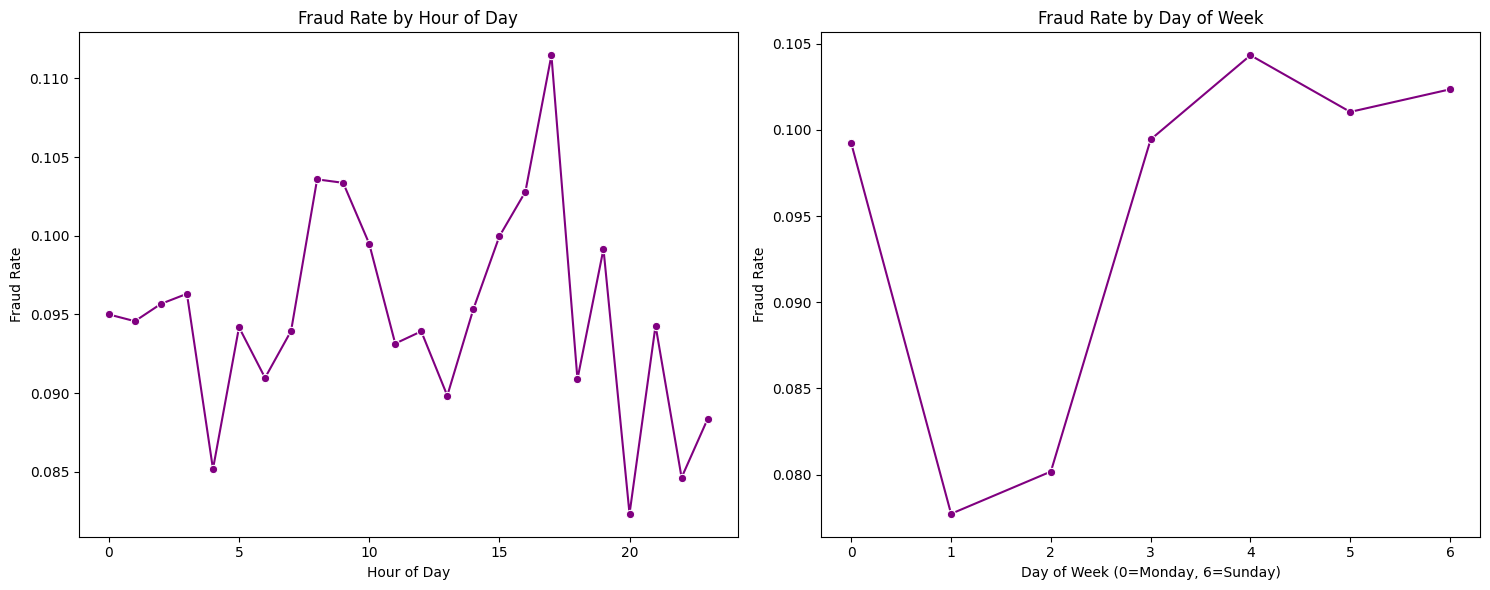

/tmp/ipykernel_157682/2021602659.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='num_unique_devices_per_user', data=fraud_data_eda, palette=['skyblue', 'salmon'])
/tmp/ipykernel_157682/2021602659.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='num_unique_users_per_device', data=fraud_data_eda, palette=['skyblue', 'salmon'])


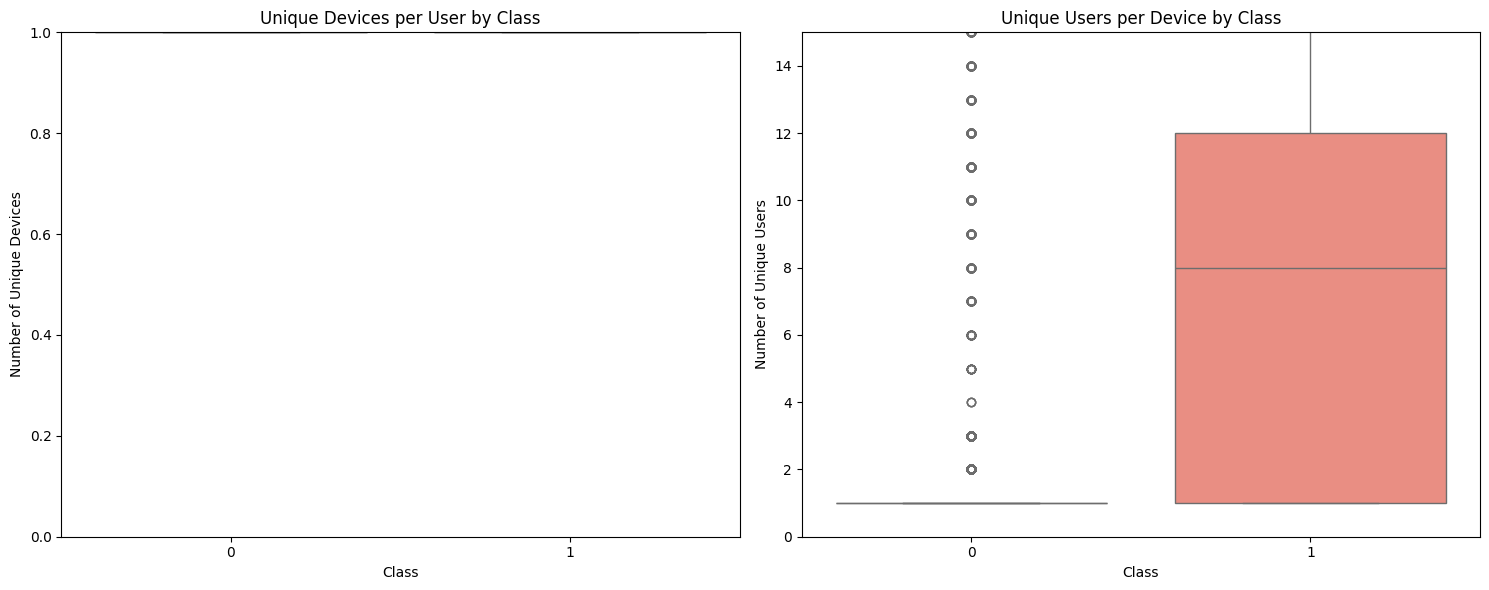


Observation: Fraudulent transactions often show unusual patterns in terms of device/user ratios.


In [ ]:
# Cell 8

if fraud_data_df.empty:
    print("Skipping Time-based and Device/User analysis as fraud_data_df is empty.")
else:
    # Hour of day and Day of week (These features are generated in feature_engineering.py but useful for EDA here)
    fraud_data_df['hour_of_day'] = fraud_data_df['purchase_time'].dt.hour
    fraud_data_df['day_of_week'] = fraud_data_df['purchase_time'].dt.dayofweek # Monday=0, Sunday=6

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x='hour_of_day', hue='class', data=fraud_data_df, palette=['skyblue', 'salmon'])
    plt.title('Transaction Count by Hour of Day and Class')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.countplot(x='day_of_week', hue='class', data=fraud_data_df, palette=['skyblue', 'salmon'])
    plt.title('Transaction Count by Day of Week and Class')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Fraud rate by hour of day and day of week
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)

    hourly_fraud_rate = fraud_data_df.groupby('hour_of_day')['class'].apply(lambda x: x.astype(int).mean())
   
    sns.lineplot(x=hourly_fraud_rate.index, y=hourly_fraud_rate.values, marker='o', color='purple')
    plt.title('Fraud Rate by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Fraud Rate')

    plt.subplot(1, 2, 2)
   
    daily_fraud_rate = fraud_data_df.groupby('day_of_week')['class'].apply(lambda x: x.astype(int).mean())
 
    sns.lineplot(x=daily_fraud_rate.index, y=daily_fraud_rate.values, marker='o', color='purple')
    plt.title('Fraud Rate by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Fraud Rate')
    plt.tight_layout()
    plt.show()

    # Consider unique device_id per user_id, or vice versa
    # This helps identify if a user logs in from many devices, or a device is used by many users.
    device_per_user = fraud_data_df.groupby('user_id')['device_id'].nunique().reset_index()
    device_per_user.rename(columns={'device_id': 'num_unique_devices_per_user'}, inplace=True)

    user_per_device = fraud_data_df.groupby('device_id')['user_id'].nunique().reset_index()
    user_per_device.rename(columns={'user_id': 'num_unique_users_per_device'}, inplace=True)

    # Merge back and explore
    fraud_data_eda = pd.merge(fraud_data_df, device_per_user, on='user_id', how='left')
    fraud_data_eda = pd.merge(fraud_data_eda, user_per_device, on='device_id', how='left')

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='class', y='num_unique_devices_per_user', data=fraud_data_eda, palette=['skyblue', 'salmon'])
    plt.title('Unique Devices per User by Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Unique Devices')
    plt.ylim(0, fraud_data_eda['num_unique_devices_per_user'].quantile(0.99)) # Clip outliers for better visualization

    plt.subplot(1, 2, 2)
    sns.boxplot(x='class', y='num_unique_users_per_device', data=fraud_data_eda, palette=['skyblue', 'salmon'])
    plt.title('Unique Users per Device by Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Unique Users')
    plt.ylim(0, fraud_data_eda['num_unique_users_per_device'].quantile(0.99))
    plt.tight_layout()
    plt.show()

    print("\nObservation: Fraudulent transactions often show unusual patterns in terms of device/user ratios.")
